In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
link = 'drive/My Drive/Colab Notebooks/APS360/'
print(device)

    100% |████████████████████████████████| 591.8MB 56.3MB/s 
fastai 1.0.48 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
cuda:0


In [4]:
class ImageFolder(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolder, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_index = (original_tuple + (index,))
        return tuple_with_index

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    

def get_data_loader(batch_size, position="samePos"):
    
    transform = transforms.Compose([transforms.Resize((150, 250)), transforms.ToTensor()])
    
    ori_data = torchvision.datasets.ImageFolder(link+'resized_images/wide', transform = transform)
    
    if position == "diffPos":
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/diffPos/3', \
                                                transform = transform)
    else:
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/samePos/3', \
                                                transform = transform)
        
        
    labeled_data = ConcatDataset(ori_data, data)
    
    trainLen = int(0.6*len(labeled_data))
    valLen = int(0.2*len(labeled_data))
    testLen = int(0.2*len(labeled_data))
    
    train_data, val_data, test_data = torch.utils.data.random_split \
    (labeled_data, [trainLen, valLen, testLen])
    
    train_data_loader = torch.utils.data.DataLoader(train_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    val_data_loader = torch.utils.data.DataLoader(val_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    test_data_loader = torch.utils.data.DataLoader(test_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    
    return train_data_loader, val_data_loader, test_data_loader

# NOTE: THIS ONLY USES ONE FOLDER!
train_data_loader, val_data_loader, test_data_loader = get_data_loader(1)
print(len(train_data_loader), len(val_data_loader), len(test_data_loader))

825 275 275


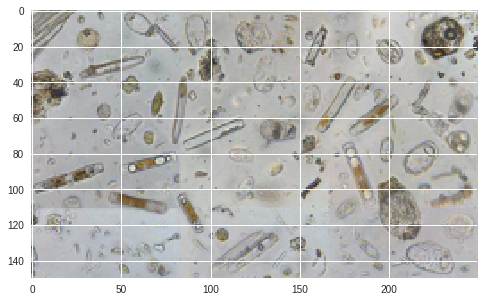

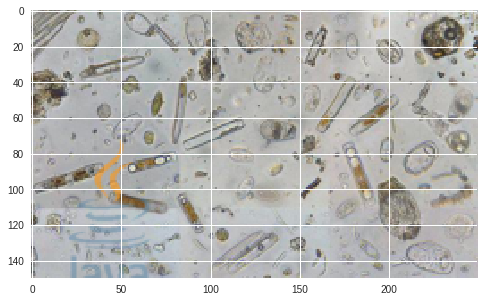

In [5]:
original, watermarked = next(iter(train_data_loader))
img_orig = torch.squeeze(original[0])
img_orig = np.transpose(img_orig, [1,2,0])
plt.imshow(img_orig)
plt.show()

img_watermarked = torch.squeeze(watermarked[0])
img_watermarked = np.transpose(img_watermarked, [1,2,0])
plt.imshow(img_watermarked)
plt.show()

In [0]:
def conv3x3(in_channels, out_channels, stride=1):
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         stride=stride, padding=1, bias=False)

class testResNetBlocks(nn.Module):

    def load_weights(self, layername):
        an_builtin = models.resnet18(pretrained=True) # Loads the pretrained model weights
        
        own_state = self.state_dict()
        
        for (name, layer) in an_builtin._modules.items():
            if name == layername:
                self.conv1.weight = layer[0]._modules['conv1'].weight
                self.conv2.weight = layer[0]._modules['conv2'].weight
            if layername == name+"-":
                self.conv1.weight = layer[1]._modules['conv1'].weight
                self.conv2.weight = layer[1]._modules['conv2'].weight
    
    def __init__(self, in_channels, out_channels, layername, stride=1, downsample=None):
        super(testResNetBlocks, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.load_weights(layername)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class testAutoencoderConv(nn.Module):
    def __init__(self, block):
        super(testAutoencoderConv, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.layers1 = self.make_layer(block, 64, "layer1")
        self.conv2 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.layers2 = self.make_layer(block, 128, "layer2")
#         self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
#         self.layers3 = self.make_layer(block, 256, "layer3")
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
    
    def make_layer(self, block, out_channels, layername, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, layername, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, 2):
            layers.append(block(out_channels, out_channels, layername+"-"))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layers1(x)
        x = self.conv2(x)
        x = self.layers2(x)
#         x = self.conv3(x)
#         x = self.layers3(x)
        x = self.decoder(x)
        return x
    
    
# resModelt = testAutoencoderConv(testResNetBlocks)
# print(resModelt)
      

In [0]:
class DilatedResNet(nn.Module):
    def __init__(self, block):
        super(DilatedResNet, self).__init__()
        
        self.in_channels = 64
        self.bottleneck_channels = 16
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.layers1 = self.make_layer(block, 64, "layer1")
#         self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
#         self.layers2 = self.make_layer(block, 128, "layer2")
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, self.bottleneck_channels, 3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
#             nn.ConvTranspose2d(64, self.bottleneck_channels, 2, stride=1, padding=1, dilation=2),
#             nn.BatchNorm2d(self.bottleneck_channels),
#             nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=4, dilation=4),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
#             nn.ConvTranspose2d(16, 3, 3, stride=1, padding=2, output_padding = 1, dilation=2),
#             nn.BatchNorm2d(3),
            nn.ConvTranspose2d(self.bottleneck_channels, 3, 3, padding=1),
#             nn.ConvTranspose2d(32, 3, 3)
#             nn.Sigmoid()
        )
    
    def make_layer(self, block, out_channels, layername, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, layername, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, 2):
            layers.append(block(out_channels, out_channels, layername+"-"))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layers1(x)
#         x = self.conv2(x)
#         x = self.layers2(x)
#         x = self.conv3(x)
#         x = self.layers3(x)
        x = self.decoder(x)
        return x

In [0]:
def get_accuracy(model, data_loader, criterion):
    total_loss, total_err, total_epoch = 0.0, 0.0, 0
    
    i = 0
    for original, watermarked in data_loader:
        ori_img, _ = original
        water_img, _ = watermarked
        ori_img = ori_img.cuda()
        water_img = water_img.cuda()
        
#         myfeatures = myfeature_model(water_img)
        recon = model(water_img)
        loss = criterion(recon, ori_img)
        
        correct = (ori_img != recon).sum().item()
        total_err += correct
        total_loss += loss.item()
        total_epoch += len(ori_img)
        i+=1
        
        if i > 10:
            break
    
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i+1)
    
    return err, loss

In [0]:
# myfeature_model = ResNetBlocks(64, 3)
# myfeature_model.cuda()

def train(model, batch_size, num_epochs=5, learning_rate=1e-4, plot=False):
    
    train_loader, val_loader, test_loader = get_data_loader(batch_size)
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_accuracies = np.zeros(num_epochs)
    val_accuracies = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_err = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    
    outputs = []
    for epoch in range(num_epochs):
        total_err = 0.0
        total_loss = 0.0
        total_epoch = 0
        
        i = 0
        for original, watermarked in train_loader:
            ori_img, _ = original
            water_img, _ = watermarked
            ori_img = ori_img.cuda()
            water_img = water_img.cuda()
            
            recon = model(water_img)
            
#             print(recon.shape, ori_img.shape)
            loss = criterion(recon, ori_img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            correct = (ori_img != recon).sum().item()
            total_err += correct
            total_loss += loss.item()
            total_epoch += len(ori_img)
            i+=1
            
            if i > 10:
                break
        
        train_accuracies[epoch] = float(total_err) / total_epoch
        train_loss[epoch] = float(total_loss) / (i+1)
        val_accuracies[epoch], val_loss[epoch] = get_accuracy(model, val_loader, criterion)
        
#         print("Epoch %d; Loss %f;  Train Acc %f" % (
#                 epoch+1, loss, train_accuracies[epoch]))
    
        print("Epoch %d; Loss %f; Val Loss %f" % (
                epoch+1, loss, val_loss[epoch]))
        
        outputs.append((epoch, water_img, recon))
    
    test_accuracy, test_loss = get_accuracy(model, test_loader, criterion)
    print("Final test loss: %f" % (test_loss))
    
    if plot == True:
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,num_epochs+1), train_loss, label="Train")
        plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

        plt.title("Train vs Validation Accuracies")
        plt.plot(range(1,num_epochs+1), train_accuracies, label="Train")
        plt.plot(range(1,num_epochs+1), val_accuracies, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()
    
    return outputs

In [10]:

resModel = DilatedResNet(testResNetBlocks)
# resModel = testAutoencoderConv(testResNetBlocks)
resModel.cuda()
outputs = train(resModel, batch_size=16, learning_rate =0.02, num_epochs=100)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 55705960.23it/s]


Epoch 1; Loss 0.027450; Val Loss 0.023705
Epoch 2; Loss 0.025714; Val Loss 0.021789
Epoch 3; Loss 0.023072; Val Loss 0.018975
Epoch 4; Loss 0.020849; Val Loss 0.016239
Epoch 5; Loss 0.018825; Val Loss 0.014289
Epoch 6; Loss 0.017163; Val Loss 0.012757
Epoch 7; Loss 0.017115; Val Loss 0.012267
Epoch 8; Loss 0.016890; Val Loss 0.011844
Epoch 9; Loss 0.016562; Val Loss 0.011705
Epoch 10; Loss 0.016456; Val Loss 0.011622
Epoch 11; Loss 0.016700; Val Loss 0.011541
Epoch 12; Loss 0.017073; Val Loss 0.011725
Epoch 13; Loss 0.016784; Val Loss 0.011822
Epoch 14; Loss 0.016101; Val Loss 0.011899
Epoch 15; Loss 0.015629; Val Loss 0.011469
Epoch 16; Loss 0.014340; Val Loss 0.011014
Epoch 17; Loss 0.013915; Val Loss 0.011266
Epoch 18; Loss 0.013423; Val Loss 0.011417
Epoch 19; Loss 0.012292; Val Loss 0.011540
Epoch 20; Loss 0.010431; Val Loss 0.010698
Epoch 21; Loss 0.008711; Val Loss 0.010038
Epoch 22; Loss 0.009071; Val Loss 0.009286
Epoch 23; Loss 0.009824; Val Loss 0.008803
Epoch 24; Loss 0.009

In [11]:
outputs = train(resModel, batch_size=16, learning_rate=0.01, num_epochs=50)

Epoch 1; Loss 0.007481; Val Loss 0.006118
Epoch 2; Loss 0.004940; Val Loss 0.004906
Epoch 3; Loss 0.003337; Val Loss 0.004840
Epoch 4; Loss 0.003421; Val Loss 0.003847
Epoch 5; Loss 0.003325; Val Loss 0.003912
Epoch 6; Loss 0.003426; Val Loss 0.004028
Epoch 7; Loss 0.003016; Val Loss 0.004081
Epoch 8; Loss 0.003095; Val Loss 0.004277
Epoch 9; Loss 0.003006; Val Loss 0.004270
Epoch 10; Loss 0.003040; Val Loss 0.003819
Epoch 11; Loss 0.004468; Val Loss 0.003875
Epoch 12; Loss 0.004587; Val Loss 0.004155
Epoch 13; Loss 0.004207; Val Loss 0.003593
Epoch 14; Loss 0.003903; Val Loss 0.003394
Epoch 15; Loss 0.003704; Val Loss 0.003396
Epoch 16; Loss 0.003546; Val Loss 0.003459
Epoch 17; Loss 0.003481; Val Loss 0.003512
Epoch 18; Loss 0.003402; Val Loss 0.003357
Epoch 19; Loss 0.003278; Val Loss 0.003287
Epoch 20; Loss 0.003322; Val Loss 0.003377
Epoch 21; Loss 0.003299; Val Loss 0.003502
Epoch 22; Loss 0.003283; Val Loss 0.003674
Epoch 23; Loss 0.003455; Val Loss 0.003558
Epoch 24; Loss 0.003

In [12]:
outputs = train(resModel, batch_size=16, learning_rate=0.001, num_epochs=50)

Epoch 1; Loss 0.002533; Val Loss 0.002230
Epoch 2; Loss 0.002126; Val Loss 0.002221
Epoch 3; Loss 0.002282; Val Loss 0.002235
Epoch 4; Loss 0.002328; Val Loss 0.002215
Epoch 5; Loss 0.002255; Val Loss 0.002203
Epoch 6; Loss 0.002223; Val Loss 0.002190
Epoch 7; Loss 0.002225; Val Loss 0.002187
Epoch 8; Loss 0.002219; Val Loss 0.002181
Epoch 9; Loss 0.002206; Val Loss 0.002175
Epoch 10; Loss 0.002197; Val Loss 0.002168
Epoch 11; Loss 0.002191; Val Loss 0.002163
Epoch 12; Loss 0.002185; Val Loss 0.002157
Epoch 13; Loss 0.002179; Val Loss 0.002151
Epoch 14; Loss 0.002174; Val Loss 0.002145
Epoch 15; Loss 0.002169; Val Loss 0.002140
Epoch 16; Loss 0.002163; Val Loss 0.002134
Epoch 17; Loss 0.002158; Val Loss 0.002129
Epoch 18; Loss 0.002153; Val Loss 0.002123
Epoch 19; Loss 0.002148; Val Loss 0.002118
Epoch 20; Loss 0.002144; Val Loss 0.002112
Epoch 21; Loss 0.002140; Val Loss 0.002107
Epoch 22; Loss 0.002134; Val Loss 0.002101
Epoch 23; Loss 0.002129; Val Loss 0.002096
Epoch 24; Loss 0.002

In [13]:
outputs = train(resModel, batch_size=16, learning_rate=0.001, num_epochs=50)

Epoch 1; Loss 0.001950; Val Loss 0.001921
Epoch 2; Loss 0.001885; Val Loss 0.001980
Epoch 3; Loss 0.001920; Val Loss 0.001979
Epoch 4; Loss 0.001868; Val Loss 0.001959
Epoch 5; Loss 0.001872; Val Loss 0.001967
Epoch 6; Loss 0.001850; Val Loss 0.001957
Epoch 7; Loss 0.001843; Val Loss 0.001955
Epoch 8; Loss 0.001833; Val Loss 0.001955
Epoch 9; Loss 0.001817; Val Loss 0.001949
Epoch 10; Loss 0.001809; Val Loss 0.001948
Epoch 11; Loss 0.001798; Val Loss 0.001945
Epoch 12; Loss 0.001786; Val Loss 0.001941
Epoch 13; Loss 0.001775; Val Loss 0.001939
Epoch 14; Loss 0.001765; Val Loss 0.001935
Epoch 15; Loss 0.001753; Val Loss 0.001934
Epoch 16; Loss 0.001742; Val Loss 0.001930
Epoch 17; Loss 0.001729; Val Loss 0.001929
Epoch 18; Loss 0.001719; Val Loss 0.001924
Epoch 19; Loss 0.001707; Val Loss 0.001922
Epoch 20; Loss 0.001696; Val Loss 0.001915
Epoch 21; Loss 0.001686; Val Loss 0.001915
Epoch 22; Loss 0.001673; Val Loss 0.001912
Epoch 23; Loss 0.001661; Val Loss 0.001906
Epoch 24; Loss 0.001

In [14]:
outputs = train(resModel, batch_size=16, learning_rate=0.0001, num_epochs=100)

Epoch 1; Loss 0.001420; Val Loss 0.001860
Epoch 2; Loss 0.001397; Val Loss 0.001854
Epoch 3; Loss 0.001383; Val Loss 0.001853
Epoch 4; Loss 0.001377; Val Loss 0.001848
Epoch 5; Loss 0.001374; Val Loss 0.001848
Epoch 6; Loss 0.001372; Val Loss 0.001848
Epoch 7; Loss 0.001370; Val Loss 0.001846
Epoch 8; Loss 0.001368; Val Loss 0.001847
Epoch 9; Loss 0.001367; Val Loss 0.001846
Epoch 10; Loss 0.001365; Val Loss 0.001846
Epoch 11; Loss 0.001364; Val Loss 0.001846
Epoch 12; Loss 0.001363; Val Loss 0.001845
Epoch 13; Loss 0.001362; Val Loss 0.001845
Epoch 14; Loss 0.001361; Val Loss 0.001846
Epoch 15; Loss 0.001360; Val Loss 0.001845
Epoch 16; Loss 0.001359; Val Loss 0.001845
Epoch 17; Loss 0.001358; Val Loss 0.001845
Epoch 18; Loss 0.001357; Val Loss 0.001844
Epoch 19; Loss 0.001356; Val Loss 0.001845
Epoch 20; Loss 0.001354; Val Loss 0.001844
Epoch 21; Loss 0.001353; Val Loss 0.001844
Epoch 22; Loss 0.001352; Val Loss 0.001844
Epoch 23; Loss 0.001351; Val Loss 0.001843
Epoch 24; Loss 0.001

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


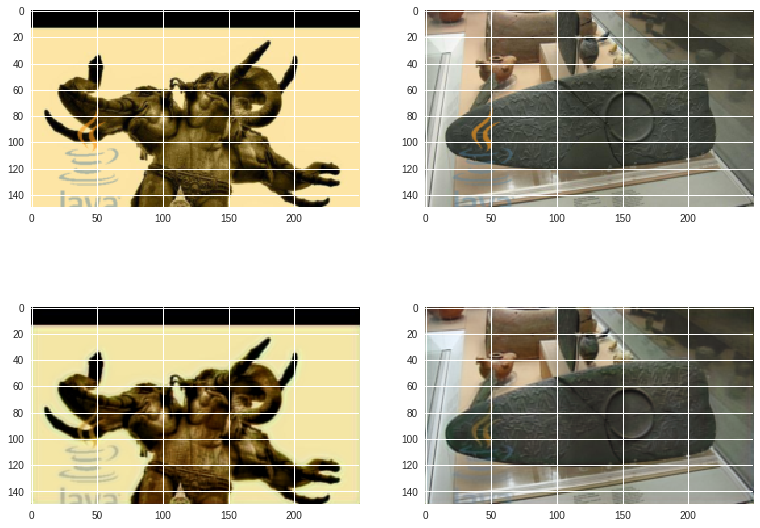

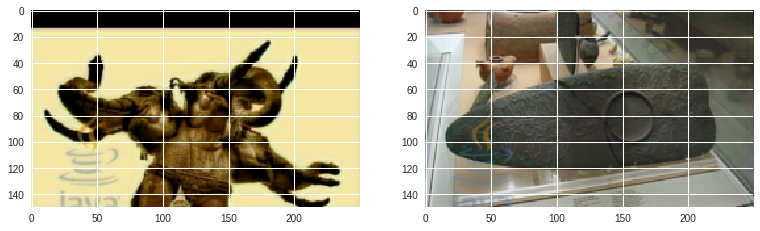

In [17]:
for k in range(0, 100, 50):
    plt.figure(figsize=(20, 10))
    imgs = outputs[k][1]
#     recon = outputs[k][2]
    recon = outputs[k][2]
    
    # print original watermarked image  
    if k == 0:
        for i, item in enumerate(imgs):
            if i >= 2: break
            
            img_orig = torch.squeeze(item)
            img_orig = np.transpose(img_orig.cpu(), [1,2,0])

            plt.subplot(2, 3, i+1)
            plt.imshow(img_orig)
        
    for i, item in enumerate(recon):
        if i >= 2: break
        
        img_recon = torch.squeeze(item)
        img_recon = np.transpose(img_recon.cpu().detach(), [1,2,0])
      
        plt.subplot(2, 3, 3+i+1)
        plt.imshow(img_recon)


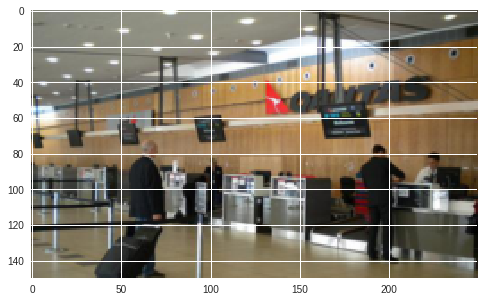

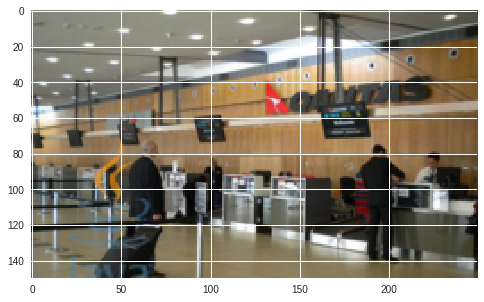

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


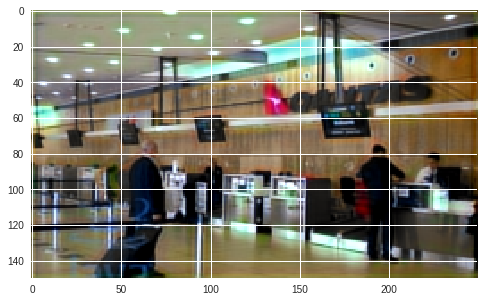

In [16]:
original, watermarked = next(iter(test_data_loader))
img_orig = torch.squeeze(original[0])
img_orig = np.transpose(img_orig, [1,2,0])
plt.imshow(img_orig)
plt.show()

img_watermarked = torch.squeeze(watermarked[0])
img_watermarked = np.transpose(img_watermarked, [1,2,0])
plt.imshow(img_watermarked)
plt.show()

recon = resModel(watermarked[0].cuda())
recon = torch.squeeze(recon)
recon = np.transpose(recon.cpu().detach(), [1,2,0])
plt.imshow(recon)
plt.show()